In [2]:
import os
import cv2
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense
from keras.applications.vgg16 import VGG16

train_path = 'train'
test_path = 'test'


### 生成训练数据

In [3]:
def make_label(file_name):
    label = file_name.split('.')[0]
    ##one-hot-encoding
    if label == 'cat': 
        return [0]
    elif label == 'dog':
        return [1]


def make_data(img_path,img_size):
    path_length = len(os.listdir(img_path))
    images = np.zeros((path_length,img_size,img_size, 3), dtype=np.uint8)
    labels = np.zeros((path_length,1),dtype=np.float32)
    count = 0
    for file_name in os.listdir(img_path):
        labels[count] = make_label(file_name)
        images[count] = cv2.resize(cv2.imread(img_path+'/'+file_name),(img_size,img_size))
        b,g,r = cv2.split(images[count])       # get b,g,r
        images[count] = cv2.merge([r,g,b])  # switch it to rgb
        count+=1
    ##shuffle
    p = np.random.permutation(path_length)
    images,labels = images[p],labels[p]
    return images,labels

#train_img, train_label = make_data(train_path,224)  ## VGG16要求的shape为224*224

#print('train_img_shape:',train_img.shape,'\ntrain_label_shape:',train_label.shape)

### 保存train_data

In [4]:
#train_img, train_label = make_data(train_path,224)  ## VGG16要求的shape为224*224
train_img, train_label = make_data(train_path,299)  ## VGG16要求的shape为299*299
#save data
np.save('train_img.npy',train_img)
np.save('train_label.npy',train_label)

### 数据可视化

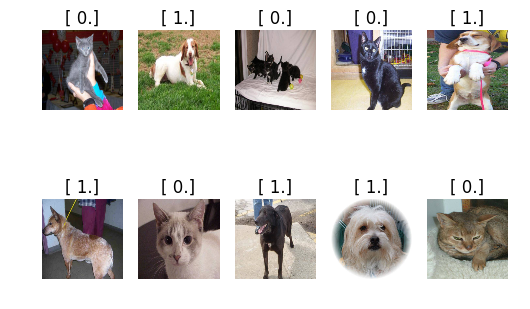

In [8]:
for i in range(10):
    index = random.randint(0, len(os.listdir(train_path)))
    plt.subplot(2, 5, i+1)
    plt.title(train_label[index])
    plt.imshow(train_img[index])
    plt.axis('off')

### 初步模型

In [11]:
input = Input(shape=(img_size, img_size, 3))
base_model = VGG16(weights='imagenet', input_tensor=input,include_top=False)

x = Flatten()(base_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input=input, output=output)


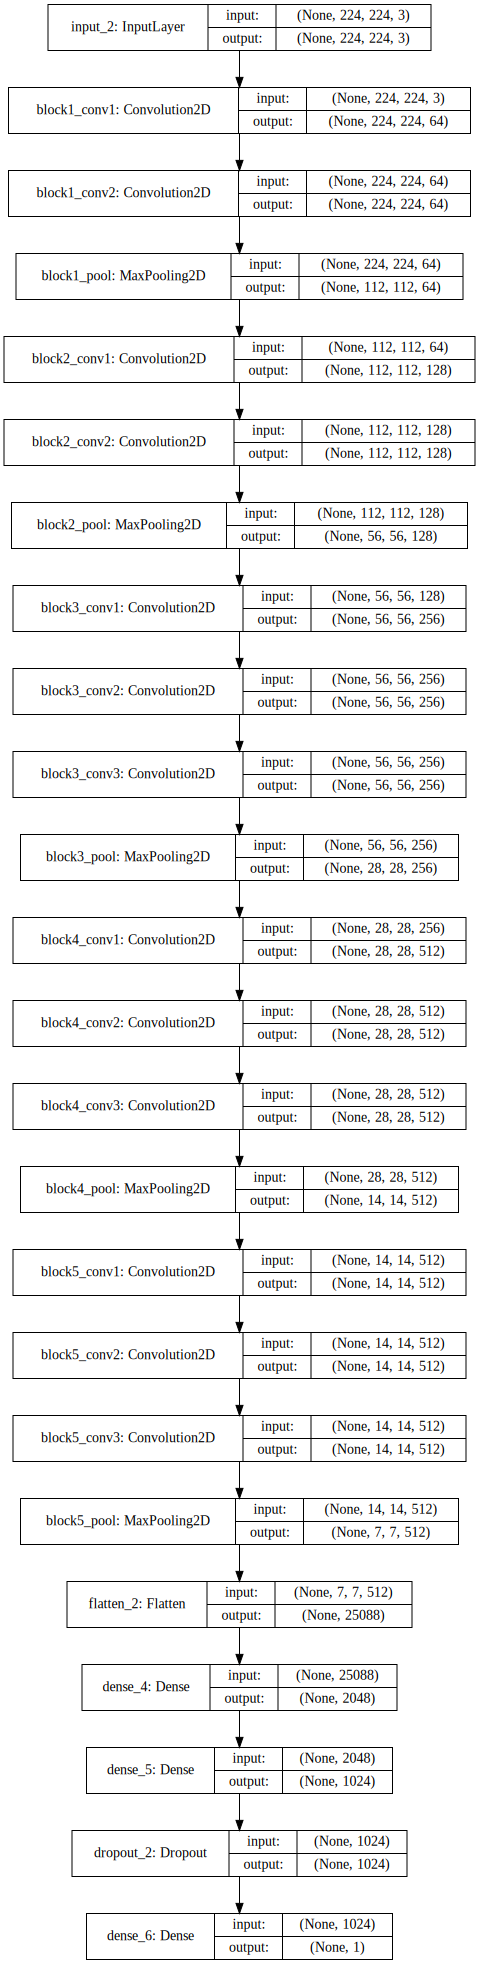

In [6]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot,plot
plot(model, to_file='model.png',show_shapes=True)
SVG(model_to_dot(model,1).create(prog='dot', format='svg'))

### 训练

In [19]:
from keras.callbacks import TensorBoard
from keras.optimizers import SGD
for layer in model.layers[:19]:
    layer.trainable = False

opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(train_img,train_label,validation_split=0.2, callbacks=[TensorBoard(log_dir='./log')])
model.save('model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 424s - loss: 0.0415 - acc: 0.9839 - val_loss: 0.0260 - val_acc: 0.9914
Epoch 2/10
20000/20000 [==============================] - 414s - loss: 0.0387 - acc: 0.9851 - val_loss: 0.0259 - val_acc: 0.9914
Epoch 3/10
20000/20000 [==============================] - 414s - loss: 0.0368 - acc: 0.9869 - val_loss: 0.0259 - val_acc: 0.9910
Epoch 4/10
20000/20000 [==============================] - 414s - loss: 0.0342 - acc: 0.9883 - val_loss: 0.0257 - val_acc: 0.9908
Epoch 5/10
20000/20000 [==============================] - 414s - loss: 0.0322 - acc: 0.9886 - val_loss: 0.0256 - val_acc: 0.9908
Epoch 6/10
20000/20000 [==============================] - 414s - loss: 0.0298 - acc: 0.9895 - val_loss: 0.0256 - val_acc: 0.9910
Epoch 7/10
20000/20000 [==============================] - 414s - loss: 0.0287 - acc: 0.9909 - val_loss: 0.0257 - val_acc: 0.9906
Epoch 8/10
20000/20000 [========================

### 训练尝试第n次

In [2]:
train_img, train_label = make_data(train_path,299)   ## Xception要求的shape为299*299

from keras.applications.xception import Xception
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

input = Input(shape=(img_size, img_size, 3))
base_model_2 = Xception(weights='imagenet', input_tensor=input,include_top=False)

x = Flatten()(base_model_2.output)
#x = Dense(2048, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.85)(x)

output = Dense(1, activation='sigmoid')(x)

model_2 = Model(input=input, output=output)

for layer in model_2.layers[:132]:    ## Xception除了top的全连接还有132层
    layer.trainable = False

opt = SGD(lr=0.0001, momentum=0.9)
model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_2.fit(train_img,train_label,validation_split=0.2, batch_size=10, callbacks=[TensorBoard(log_dir='./log')])
model_2.save('model_2.h5')
##下面其实已经训练完了，但由于网页接口端口，记录没了，详见报告中的tensorboard

<bound method Container.summary of <keras.engine.training.Model object at 0x7fecb72f52b0>>

### 生成test数据

In [11]:
test_length = len(os.listdir(test_path))
test = np.zeros((test_length,299,299, 3), dtype=np.uint8)

##生成test image
for file_name in os.listdir(test_path):
    index = int(file_name.split('.')[0])-1  #文件名和默认的index相差1
    test[index] = cv2.resize(cv2.imread(test_path+'/'+file_name),(299,299))
    b,g,r = cv2.split(test[index])       # get b,g,r
    test[index] = cv2.merge([r,g,b])  # switch it to rgb
np.save('test.npy',test)

### 预测可视化

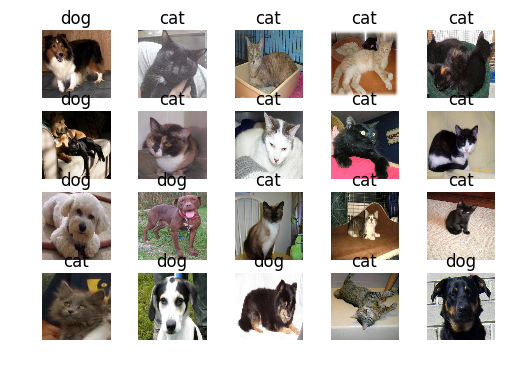

In [9]:
test = np.load('test.npy')
from keras.models import load_model
model_2 = load_model('model_2.h5')
#预测的可视化
for i in range(20):
    index=random.randint(0,len(test))
    pred = model_2.predict(test[index:index+1])
    if pred >0.5:
        title='dog'
    else:
        title='cat'
    plt.subplot(4,5,i+1)
    plt.title(title)
    plt.imshow(test[index])
    plt.axis('off')


### 生成csv

In [ ]:
##将预测写入csv
with open('file.csv','w') as f:
    f.write('id,label\n')
with open('file.csv','a') as f:
    for i in range(len(test)):
        pred = model_3.predict(test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))


### 重新载入数据

In [8]:
from keras.models import load_model
model = load_model('model.h5')
model_2 = load_model('model_2.h5')
test = np.load('test.npy')
train_img = np.load('train_img.npy')
train_label = np.load('train_label.npy')
print(train_img.shape,train_label.shape)

(25000, 224, 224, 3) (25000, 1)


### 分割数据

In [31]:
#分割train_data,valid_data，用于等下的数据生成
index = int(len(train_img)*0.8)
train_images,valid_images = train_img[:index], train_img[index:]
train_labels,valid_labels = train_label[:index], train_label[index:]
print(train_images.shape,valid_images.shape)
print(train_labels.shape,valid_labels.shape)

(20000, 299, 299, 3) (5000, 299, 299, 3)
(20000, 1) (5000, 1)


### 数据进一步处理

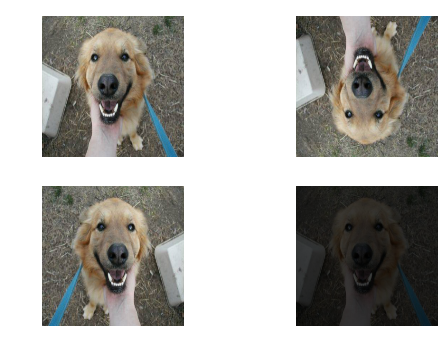

In [29]:
from scipy.ndimage.interpolation import shift
def img_change_brightness(img): 
    # Convert the image to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Compute a random brightness value and apply to the image
    brightness = np.random.uniform(0.25,1) ##调整范围在0.25到1之间
    img[:, :, 2] = img[:, :, 2] * brightness
    # Convert back to RGB
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

index = random.randint(0,len(train_images))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = [train_images[index],                         #原图
           np.flipud(train_images[index]),              #上下翻转
           np.fliplr(train_images[index]),              #左右翻转
           img_change_brightness(train_images[index])]  #亮度调整 
    plt.imshow(img[i])
    plt.axis('off')

In [32]:
#随机将25%的训练数据进行亮度调整
for i in range(int(len(train_images)*0.25)):
    index = random.randint(0,len(train_images))
    train_images[index] = img_change_brightness(train_images[index])
#随机将25%的训练数据进行左右翻转
for i in range(int(len(train_images)*0.25)):
    index = random.randint(0,len(train_images))
    train_images[index] = np.fliplr(train_images[index])
#随机将25%的训练数据进行上下翻转
for i in range(int(len(train_images)*0.25)):
    index = random.randint(0,len(train_images))
    train_images[index] = np.flipud(train_images[index])

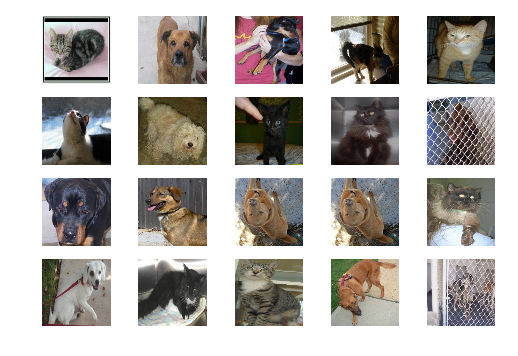

In [33]:
for i in range(20):
    index = random.randint(0,len(train_images))
    plt.subplot(4,5,i+1)
    plt.imshow(train_images[index])
    plt.axis('off')

### 模型n，训练n

In [ ]:
from keras.callbacks import TensorBoard
from keras.models import load_model
model_3 = load_model('model_2.h5')
model_3.fit(train_images,train_labels,validation_data=(valid_images,valid_labels), batch_size=16, callbacks=[TensorBoard(log_dir='./log')])
model_3.save('model_3.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 736s - loss: 0.1101 - acc: 0.9548 - val_loss: 0.0203 - val_acc: 0.9940
Epoch 2/10
20000/20000 [==============================] - 735s - loss: 0.0937 - acc: 0.9635 - val_loss: 0.0183 - val_acc: 0.9946
Epoch 3/10
20000/20000 [==============================] - 735s - loss: 0.0826 - acc: 0.9672 - val_loss: 0.0212 - val_acc: 0.9928
Epoch 4/10
20000/20000 [==============================] - 735s - loss: 0.0794 - acc: 0.9676 - val_loss: 0.0211 - val_acc: 0.9930
Epoch 5/10
20000/20000 [==============================] - 735s - loss: 0.0713 - acc: 0.9725 - val_loss: 0.0200 - val_acc: 0.9924
Epoch 6/10
20000/20000 [==============================] - 735s - loss: 0.0671 - acc: 0.9740 - val_loss: 0.0192 - val_acc: 0.9932
Epoch 7/10
20000/20000 [==============================] - 735s - loss: 0.0644 - acc: 0.9770 - val_loss: 0.0202 - val_acc: 0.9928
Epoch 8/10
20000/20000 [========================